# Photon - Electron vision transformer
The Classical Vision Transformer is used as a benchmark for the Quantum Vision Transformer, which can handle images with a maximum resolution of 16 pixels. To accommodate this, I divided each image into four patches and applied PCA to each patch of the dataset. The same PCA transformation was used for every patch, reducing them to four dimensions each. Subsequently, I built the model using a Transformer implemented with TensorFlow.

In [2]:
import h5py

with h5py.File('photon.hdf5', 'r') as photon_file:
    print("Photon file keys: ", list(photon_file.keys()))
    photon_data = photon_file['X'][:]
    photon_labels = photon_file['y'][:]

with h5py.File('electron.hdf5', 'r') as electron_file:
    print("Electron file keys: ", list(electron_file.keys()))
    electron_data = electron_file['X'][:]
    electron_labels = electron_file['y'][:]

electron_data.shape, electron_labels.shape, photon_data.shape, photon_labels.shape

Photon file keys:  ['X', 'y']
Electron file keys:  ['X', 'y']


((249000, 32, 32, 2), (249000,), (249000, 32, 32, 2), (249000,))

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

print("Default GPU Device: {}".format(tf.test.gpu_device_name()))

Default GPU Device: /device:GPU:0


In [4]:
# Combine the data and labels from both photon and electron datasets
all_data = np.concatenate([photon_data[:50000], electron_data[:50000]], axis=0)
all_labels = np.concatenate([photon_labels[:50000], electron_labels[:50000]], axis=0)

# Split the combined dataset into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(
    all_data, all_labels, test_size=0.2, random_state=42  # 20% data as test set
)

print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Testing images shape:", test_images.shape)
print("Testing labels shape:", test_labels.shape)

Training images shape: (80000, 32, 32, 2)
Training labels shape: (80000,)
Testing images shape: (20000, 32, 32, 2)
Testing labels shape: (20000,)


In [5]:
np.concatenate([train_images[:, :16, :16, 0], train_images[:, :16, :16, 1]], axis=1).reshape(80000, -1).shape

(80000, 512)

In [6]:
# Extract quadrants
first_quadrant_train = np.concatenate([train_images[:, :16, :16, 0], train_images[:, :16, :16, 1]], axis=1).reshape(80000, -1)
second_quadrant_train = np.concatenate([train_images[:, :16, 16:, 0], train_images[:, :16, 16:, 1]], axis=1).reshape(80000, -1)
third_quadrant_train = np.concatenate([train_images[:, 16:, :16, 0], train_images[:, 16:, :16, 1]], axis=1).reshape(80000, -1)
fourth_quadrant_train = np.concatenate([train_images[:, 16:, 16:, 0], train_images[:, 16:, 16:, 1]], axis=1).reshape(80000, -1)

# Concatenate quadrants along columns
concatenated_data = np.concatenate([first_quadrant_train, second_quadrant_train, third_quadrant_train, fourth_quadrant_train], axis=0)

# Apply PCA
pca = PCA(n_components=4)
concatenated_pca = pca.fit_transform(concatenated_data)

# Transform each quadrant separately using the same PCA
first_quadrant_pca_train = pca.transform(first_quadrant_train)
second_quadrant_pca_train = pca.transform(second_quadrant_train)
third_quadrant_pca_train = pca.transform(third_quadrant_train)
fourth_quadrant_pca_train = pca.transform(fourth_quadrant_train)

# Display the shape of the transformed quadrants
first_quadrant_pca_train.shape, second_quadrant_pca_train.shape, third_quadrant_pca_train.shape, fourth_quadrant_pca_train.shape

((80000, 4), (80000, 4), (80000, 4), (80000, 4))

In [7]:
patch_pca_train = np.concatenate([first_quadrant_pca_train[:, :2], second_quadrant_pca_train[:, :2],
                                  first_quadrant_pca_train[:, 2:], second_quadrant_pca_train[:, 2:],
                                  third_quadrant_pca_train[:, :2], fourth_quadrant_pca_train[:, :2],
                                  third_quadrant_pca_train[:, 2:], fourth_quadrant_pca_train[:, 2:]], axis=1).reshape(-1, 4, 4, 1)

In [8]:
# Extract quadrants
first_quadrant_test = np.concatenate([test_images[:, :16, :16, 0], test_images[:, :16, :16, 1]], axis=1).reshape(20000, -1)
second_quadrant_test = np.concatenate([test_images[:, :16, 16:, 0], test_images[:, :16, 16:, 1]], axis=1).reshape(20000, -1)
third_quadrant_test = np.concatenate([test_images[:, 16:, :16, 0], test_images[:, 16:, :16, 1]], axis=1).reshape(20000, -1)
fourth_quadrant_test = np.concatenate([test_images[:, 16:, 16:, 0], test_images[:, 16:, 16:, 1]], axis=1).reshape(20000, -1)

In [9]:
# Transform each quadrant separately using the same PCA
first_quadrant_pca_test = pca.transform(first_quadrant_test)
second_quadrant_pca_test = pca.transform(second_quadrant_test)
third_quadrant_pca_test = pca.transform(third_quadrant_test)
fourth_quadrant_pca_test = pca.transform(fourth_quadrant_test)

patch_pca_test = np.concatenate([first_quadrant_pca_test[:, :2], second_quadrant_pca_test[:, :2],
                                  first_quadrant_pca_test[:, 2:], second_quadrant_pca_test[:, 2:],
                                  third_quadrant_pca_test[:, :2], fourth_quadrant_pca_test[:, :2],
                                  third_quadrant_pca_test[:, 2:], fourth_quadrant_pca_test[:, 2:]], axis=1).reshape(-1, 4, 4, 1)

In [10]:
# Convert the labels to one-hot encoded vectors
train_labels = to_categorical(train_labels, 2)
test_labels = to_categorical(test_labels, 2)

In [11]:
class PatchExtractor(Layer):
    def __init__(self, patch_size=2):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size  # Initialize patch size

    def call(self, images):
        # Calculate the batch size from the images tensor
        batch_size = tf.shape(images)[0]
        # Extract patches from images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],  # Size of patches to extract
            strides=[1, self.patch_size, self.patch_size, 1],  # Stride for each patch
            rates=[1, 1, 1, 1],  # Dilation rate, set to 1 meaning no dilation
            padding="VALID",  # Use valid padding, no padding is applied
        )
        # Reshape the patches to have the patch dimension flattened
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        return patches

In [12]:
class PatchEncoder(Layer):
    def __init__(self, num_patches=4, projection_dim=2*2):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches  # Total number of patches
        self.projection_dim = projection_dim  # Dimension to project each patch onto
        # Initialize weights for the class token
        w_init = tf.random_normal_initializer()
        self.class_token = tf.Variable(initial_value=w_init(shape=(1, projection_dim), dtype="float32"), trainable=True)
        self.projection = Dense(units=projection_dim)  # Dense layer to project patch features
        self.position_embedding = Embedding(input_dim=num_patches + 1, output_dim=projection_dim)  # Positional embeddings

    def call(self, patches):
        batch_size = tf.shape(patches)[0]  # Calculate the batch size
        # Repeat the class token for each item in the batch
        class_token = tf.tile(self.class_token, multiples=[batch_size, 1])
        class_token = tf.reshape(class_token, (batch_size, 1, self.projection_dim))
        # Project the patches to the specified dimension
        patches_embed = self.projection(patches)
        # Concatenate the class token with the projected patches
        patches_embed = tf.concat([class_token, patches_embed], axis=1)
        # Calculate positional embeddings for all patches + class token
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        positions_embed = self.position_embedding(positions)
        # Add positional embeddings to the concatenated embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [13]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        # First dense layer with GELU activation
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        # Second dense layer for output features
        self.dense2 = Dense(out_features)
        # Dropout layer
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        # Apply first dense layer
        x = self.dense1(x)
        # Apply dropout
        x = self.dropout(x)
        # Apply second dense layer
        x = self.dense2(x)
        # Apply dropout again
        y = self.dropout(x)
        return y

In [14]:
class Block(Layer):
    def __init__(self, projection_dim, num_heads=4, dropout_rate=0.1):
        super(Block, self).__init__()
        # First layer normalization
        self.norm1 = LayerNormalization(epsilon=1e-6)
        # Multi-head attention layer
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        # Second layer normalization
        self.norm2 = LayerNormalization(epsilon=1e-6)
        # MLP for further processing
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        # Apply first layer normalization
        x1 = self.norm1(x)
        # Apply multi-head attention
        attention_output = self.attn(x1, x1)
        # Add residual connection after attention
        x2 = Add()([attention_output, x])
        # Apply second layer normalization
        x3 = self.norm2(x2)
        # Apply MLP
        x3 = self.mlp(x3)
        # Add residual connection after MLP
        y = Add()([x3, x2])
        return y

In [15]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=4, num_blocks=3, dropout_rate=0.1):
        super(TransformerEncoder, self).__init__()
        # Define blocks of transformer encoder
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        # Final layer normalization
        self.norm = LayerNormalization(epsilon=1e-6)
        # Final dropout layer
        self.dropout = Dropout(0.1)

    def call(self, x):
        # Pass input through each block
        for block in self.blocks:
            x = block(x)
        # Apply final layer normalization
        x = self.norm(x)
        # Apply final dropout
        y = self.dropout(x)
        return y

In [16]:
def create_VisionTransformer(num_classes, num_patches=4, projection_dim=2*2, input_shape=(4, 4, 1)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = Dense(num_classes, activation='softmax')(representation)
    # Create model
    model = Model(inputs=inputs, outputs=logits)
    return model
model = create_VisionTransformer(2)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 4, 1)]         0         
                                                                 
 patch_extractor (PatchExtr  (None, None, 4)           0         
 actor)                                                          
                                                                 
 patch_encoder (PatchEncode  (None, 5, 4)              44        
 r)                                                              
                                                                 
 transformer_encoder (Trans  (None, 5, 4)              1208      
 formerEncoder)                                                  
                                                                 
 global_average_pooling1d (  (None, 4)                 0         
 GlobalAveragePooling1D)                                     

In [17]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

In [18]:
history = model.fit(
    patch_pca_train, train_labels,
    epochs=10,
    batch_size=32,
    validation_data=(patch_pca_test, test_labels)
)

Epoch 1/10
2500/2500 [==============================] - 49s 14ms/step - loss: 0.6939 - accuracy: 0.5114 - auc: 0.5156 - val_loss: 0.6862 - val_accuracy: 0.5504 - val_auc: 0.5692
Epoch 2/10
2500/2500 [==============================] - 35s 14ms/step - loss: 0.6846 - accuracy: 0.5612 - auc: 0.5745 - val_loss: 0.6813 - val_accuracy: 0.5691 - val_auc: 0.5928
Epoch 3/10
2500/2500 [==============================] - 34s 13ms/step - loss: 0.6807 - accuracy: 0.5695 - auc: 0.5882 - val_loss: 0.6792 - val_accuracy: 0.5746 - val_auc: 0.5932
Epoch 4/10
2500/2500 [==============================] - 36s 14ms/step - loss: 0.6795 - accuracy: 0.5705 - auc: 0.5901 - val_loss: 0.6773 - val_accuracy: 0.5742 - val_auc: 0.5934
Epoch 5/10
2500/2500 [==============================] - 35s 14ms/step - loss: 0.6790 - accuracy: 0.5697 - auc: 0.5905 - val_loss: 0.6770 - val_accuracy: 0.5732 - val_auc: 0.5968
Epoch 6/10
2500/2500 [==============================] - 34s 14ms/step - loss: 0.6780 - accuracy: 0.5726 - auc:

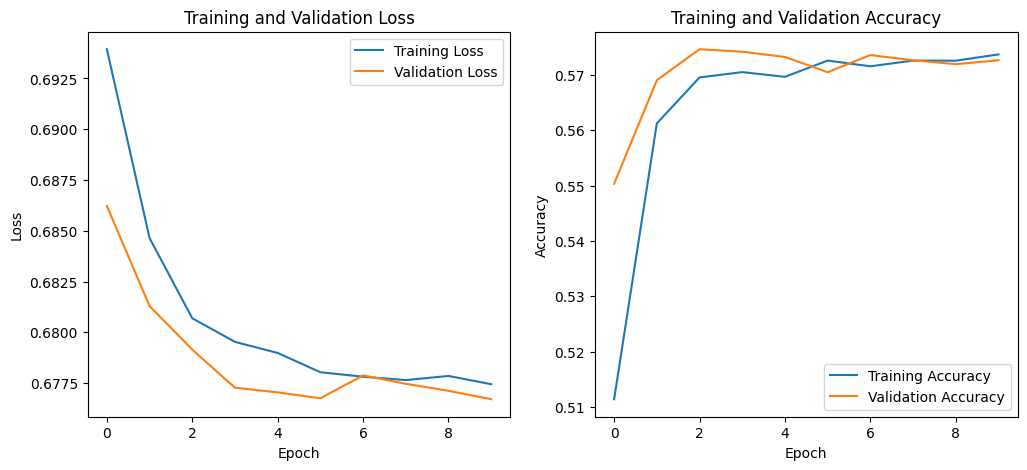

In [19]:
# Plot the training and validation loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()